In [1]:
# Detect Multicollinearity 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# 1. heatmap for pair-wise correlations

credit = pd.read_csv("Credit.csv")
credit['Income'] = pd.to_numeric(credit['Income'])
credit.sample(5)

,Unnamed: 0,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
211,212,29.567,5309,397,3,25,15,Male,No,No,Caucasian,799
349,350,48.577,5145,389,3,71,13,Female,No,Yes,Asian,503
35,36,23.350,2558,220,3,49,12,Female,Yes,No,Caucasian,419
389,390,83.948,7100,503,2,44,18,Male,No,No,Caucasian,806
393,394,17.316,1335,138,2,65,13,Male,No,No,African American,0


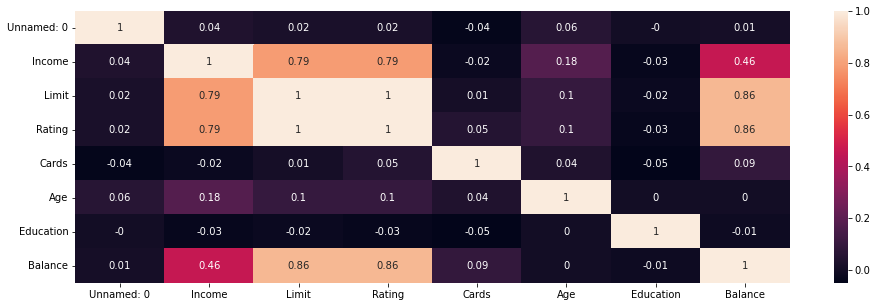

In [4]:
import seaborn as sns
correlation_matrix = credit.corr().round(2)
plt.figure(figsize = (16,5))
sns.heatmap(data=correlation_matrix, annot=True)



<b>Note</b>

- only numeric variables would show up 
- Think: how to measure the "correlation" between categorical variables? or categorical avriable v.s. numerical variable? 

Problem with idesntifying with correlations:
- It's pair-wise relationship, does not evaluate all features together
- It doesn't show result for categorical variables. 

In [4]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
y, X = dmatrices('Balance~Income + Limit + Rating +Cards+Age +Education +Gender+Student+Married+Ethnicity', data=credit, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

    VIF Factor                features
0    52.451853               Intercept
1     1.005849        Gender[T.Female]
2     1.031517          Student[T.Yes]
3     1.044638          Married[T.Yes]
4     1.552157      Ethnicity[T.Asian]
5     1.527504  Ethnicity[T.Caucasian]
6     2.786182                  Income
7   234.028100                   Limit
8   235.848259                  Rating
9     1.448690                   Cards
10    1.051410                     Age
11    1.019588               Education


Limit and Rating are identified as varaibles that is causing the multicolinearity problem. Since they are highly correlated, we can consider deleting one. Let's try to delate Limit.

In [5]:
#delete Limit, much better. 
y, X_new = dmatrices('Balance~Income + Rating +Cards+Age +Education +Gender+Student+Married+Ethnicity', data=credit, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_new.values, i) for i in range(X_new.shape[1])]
vif["features"] = X_new.columns
print(vif)

# The intercept contributes a lot in varation, but we never drop it easily. 
# Especially you can see from the summary table that it's significantly away from 0. 

    VIF Factor                features
0    46.513331               Intercept
1     1.005848        Gender[T.Female]
2     1.022092          Student[T.Yes]
3     1.032237          Married[T.Yes]
4     1.546515      Ethnicity[T.Asian]
5     1.527415  Ethnicity[T.Caucasian]
6     2.784966                  Income
7     2.730561                  Rating
8     1.019639                   Cards
9     1.051135                     Age
10    1.013503               Education


In [6]:
# fit initial model 
model =smf.ols('Balance~Income + Rating +Cards+Age +Education +Gender+Student+Married+Ethnicity',data=credit).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Balance   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     757.8
Date:                Sun, 08 Nov 2020   Prob (F-statistic):          4.46e-248
Time:                        15:40:19   Log-Likelihood:                -2415.4
No. Observations:                 400   AIC:                             4853.
Df Residuals:                     389   BIC:                             4897.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               -549.3140     35.085    -15.657      0.000    -618.293    -480.335
Gender[T.Female]         -10.7106     10.325     -1.037      0.300     -31.010       9.589
Student[T.Yes]           416.4376     17.336     24.021      0.000     382.353     450.522
Married[T.Yes]           -15.1096     10.728     -1.408      0.160     -36.202       5.983
Ethnicity[T.Asian]        21.7616     14.678      1.483      0.139      -7.096      50.619
Ethnicity[T.Caucasian]    10.6492     12.716      0.837      0.403     -14.351      35.649
Income                    -7.7746      0.244    -31.878      0.000      -8.254      -7.295
Rating                     3.9790      0.055     72.332      0.000       3.871       4.087
Cards                      3.9654      3.793      1.045      0.296      -3.492      11.422
Age                       -0.6416      0.306     -2.096      0.037      -1.243      -0.040
Education                 -0.3799      1.659     -0.229      0.819      -3.642       2.882
==============================================================================
Omnibus:                       15.651   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.769
Skew:                           0.490   Prob(JB):                     0.000228
Kurtosis:                       2.789   Cond. No.                     2.73e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.73e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [7]:
# Inluential points
#object for the analysis of influential points
infl = model.get_influence()
#members
print(dir(infl))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_drop_vari', '_ols_xnoti', '_plot_index', '_res_looo', 'aux_regression_endog', 'aux_regression_exog', 'cooks_distance', 'cov_ratio', 'det_cov_params_not_obsi', 'dfbeta', 'dfbetas', 'dffits', 'dffits_internal', 'endog', 'ess_press', 'exog', 'get_resid_studentized_external', 'hat_diag_factor', 'hat_matrix_diag', 'influence', 'k_vars', 'model_class', 'nobs', 'params_not_obsi', 'plot_index', 'plot_influence', 'resid', 'resid_press', 'resid_std', 'resid_studentized', 'resid_studentized_external', 'resid_studentized_internal', 'resid_var', 'results', 'scale', 'sigma2_not_obsi', 'summary_frame', 'summary_table']


In [8]:
#externally studentized residuals
print(infl.resid_studentized_external[1:5]) #just the first 5 obs as example

[-0.11133069 -0.89373531 -0.34074765 -0.5816827 ]


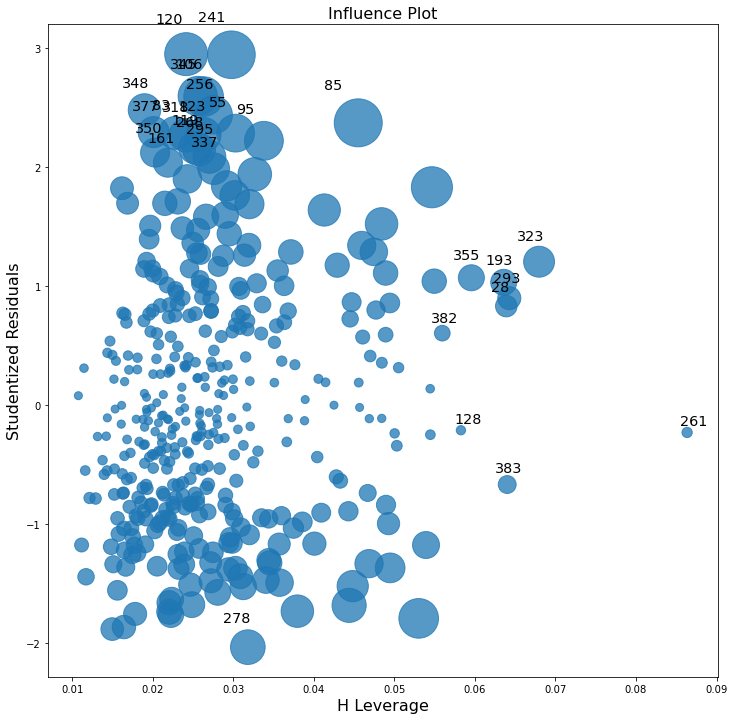

In [9]:
#graphical representation of the influences()
fig, ax = plt.subplots(figsize=(12,12))
fig=sm.graphics.influence_plot(model,ax=ax, criterion="cooks") 
#size of points are given by cook's dist value
#the points with big size and out of the (-3,3) should raise a flag

In [10]:
#threshold externally studentized residuals
import scipy
n=400
p=11
seuil_stud = scipy.stats.t.ppf(0.975,df=n-p-1)
#detection - absolute value > threshold
reg_studs=infl.resid_studentized_external
atyp_stud = np.abs(reg_studs) > seuil_stud
#which ones?
print(credit.index[atyp_stud],reg_studs[atyp_stud])

Int64Index([ 55,  83,  85,  95, 106, 119, 120, 123, 161, 241, 256, 268, 278,
            295, 318, 337, 345, 348, 350, 377],
           dtype='int64') [ 2.28363253  2.28558871  2.37028027  2.21911588  2.59050845  2.16225126
  2.94701144  2.26873769  2.03549831  2.9417433   2.43680305  2.14677707
 -2.03173247  2.08414568  2.2657838   1.98497377  2.59557321  2.47831419
  2.12056825  2.29228244]


In [11]:
#Cook's distance
inflsum=infl.summary_frame()
reg_cook=inflsum.cooks_d

atyp_cook = np.abs(reg_cook) >= 4/n
print(credit.index[atyp_cook],reg_cook[atyp_cook])

Int64Index([ 55,  62,  83,  85,  95,  96, 102, 106, 119, 120, 121, 123, 222,
            241, 242, 256, 268, 278, 295, 318, 320, 337, 345, 348],
           dtype='int64') 55     0.014648
62     0.011448
83     0.010944
85     0.024069
95     0.015506
96     0.017486
102    0.010466
106    0.016248
119    0.010913
120    0.019160
121    0.010675
123    0.012506
222    0.010672
241    0.023672
242    0.011871
256    0.015080
268    0.010974
278    0.012229
295    0.010881
318    0.011399
320    0.016217
337    0.010079
345    0.015846
348    0.010658
Name: cooks_d, dtype: float64
